In [1]:
import pandas as pd

## Corrigindo dados com linhas quebradas

In [48]:
def format_line(line):
    '''Função para arrumar linhas erradas'''
    return line.replace(',""', ',"')\
               .replace('"",', '",')\
               .strip('"')\
               .replace('"\n', '\n')

with open("dados_clones.csv", "r") as open_file:
    data = open_file.readlines()
    
new_data = [ format_line(i) for i in data[:-1] ]

# Salvando os dados em um novo arquivo
with open("dados_corrigidos.csv", "w") as open_file:
    open_file.writelines(new_data)

### Leitura do arquivo correto

In [61]:
df = pd.read_csv( "dados_corrigidos.csv", decimal="," )

In [62]:
# Tamanho da base de dados
df.shape

(1077281, 9)

In [63]:
df["p2o_master_id"].nunique()

1047693

In [64]:
# Quem são os clones repetidos nesse caraio?
pd.value_counts(df["p2o_master_id"]).head(3)

8198108     2
9584411     2
10281295    2
Name: p2o_master_id, dtype: int64

In [65]:
# Evidência de que temos o mesmo id para clones 
# com características diferentes
df[df["p2o_master_id"] == 8198108]

,p2o_master_id,Massa(em kilos),General Jedi encarregado,Estatura(cm),Distância Ombro a ombro,Tamanho do crânio,Tamanho dos pés,Tempo de existência(em meses),Status
809172,8198108,83.94,Mace Windu,180.44,Tipo 5,Tipo 1,Tipo 1,27.3,Apto
925197,8198108,84.45,Yoda,180.95,Tipo 2,Tipo 5,Tipo 3,15.6,Apto


In [68]:
df = df.sort_values( by="Tempo de existência(em meses)",
                     ascending=False )

df = df.drop_duplicates(subset=["p2o_master_id"], keep="first")

In [70]:
# Análise bivariada dos jedis
pd.crosstab( df["Status "], df["General Jedi encarregado"] )

General Jedi encarregado,Aayla Secura,Mace Windu,Obi-Wan Kenobi,Shaak Ti,Yoda
Status,,,,,
Apto,192462,193230,192583,180004,179651
Defeituoso,0,0,0,54932,54831


In [71]:
# Análise bivariada dos Ombro
pd.crosstab( df["Status "], df["Distância Ombro a ombro"] )

Distância Ombro a ombro,Tipo 1,Tipo 2,Tipo 3,Tipo 4,Tipo 5
Status,,,,,
Apto,186867,187772,188024,188054,187213
Defeituoso,21827,21961,22058,21808,22109


In [73]:
# Análise bivariada dos Crânios
pd.crosstab( df["Status "], df["Tamanho do crânio"] )

Tamanho do crânio,Tipo 1,Tipo 2,Tipo 3,Tipo 4,Tipo 5
Status,,,,,
Apto,187754,187591,187509,187185,187891
Defeituoso,22035,21657,21839,22180,22052


In [74]:
# Análise bivariada dos Crânios
pd.crosstab( df["Status "], df["Tamanho dos pés"] )

Tamanho dos pés,Tipo 1,Tipo 2,Tipo 3,Tipo 4,Tipo 5
Status,,,,,
Apto,187939,187187,187209,187525,188070
Defeituoso,21951,21996,21824,22005,21987


In [82]:
numericos = df.dtypes[ df.dtypes == 'float64' ].index.tolist()

df.groupby(by="Status ")[numericos].mean()

,Massa(em kilos),Estatura(cm),Tempo de existência(em meses)
Status,,,
Apto,83.765946,180.605468,23.401384
Defeituoso,83.200101,180.400181,31.613948


## E se usarmos uma árvore de decisão?

### Será que um algoritmo de Aprendizado de Máquina ajuda a descrever?

In [90]:
from sklearn import tree
from sklearn import preprocessing
from sklearn.tree import plot_tree 
import matplotlib.pyplot as plt

### Primeira rodada com todas vairáveis!!

In [96]:
target = "Status "
features = df.columns.tolist()[1:-1]
features_cat = df[features].dtypes[ df[features].dtypes == "object" ].index.tolist()
features_num = list(set(features) - set(features_cat))

In [122]:
# Esse caraio aqui que é o o pre processamento

onehot = preprocessing.OneHotEncoder(sparse=False)
onehot.fit(df[features_cat])
df_onehot = pd.DataFrame( onehot.transform(df[features_cat]),
                          columns=onehot.get_feature_names(features_cat))

df_fit = pd.concat( [df[features_num].reset_index(drop=True), df_onehot], axis=1)

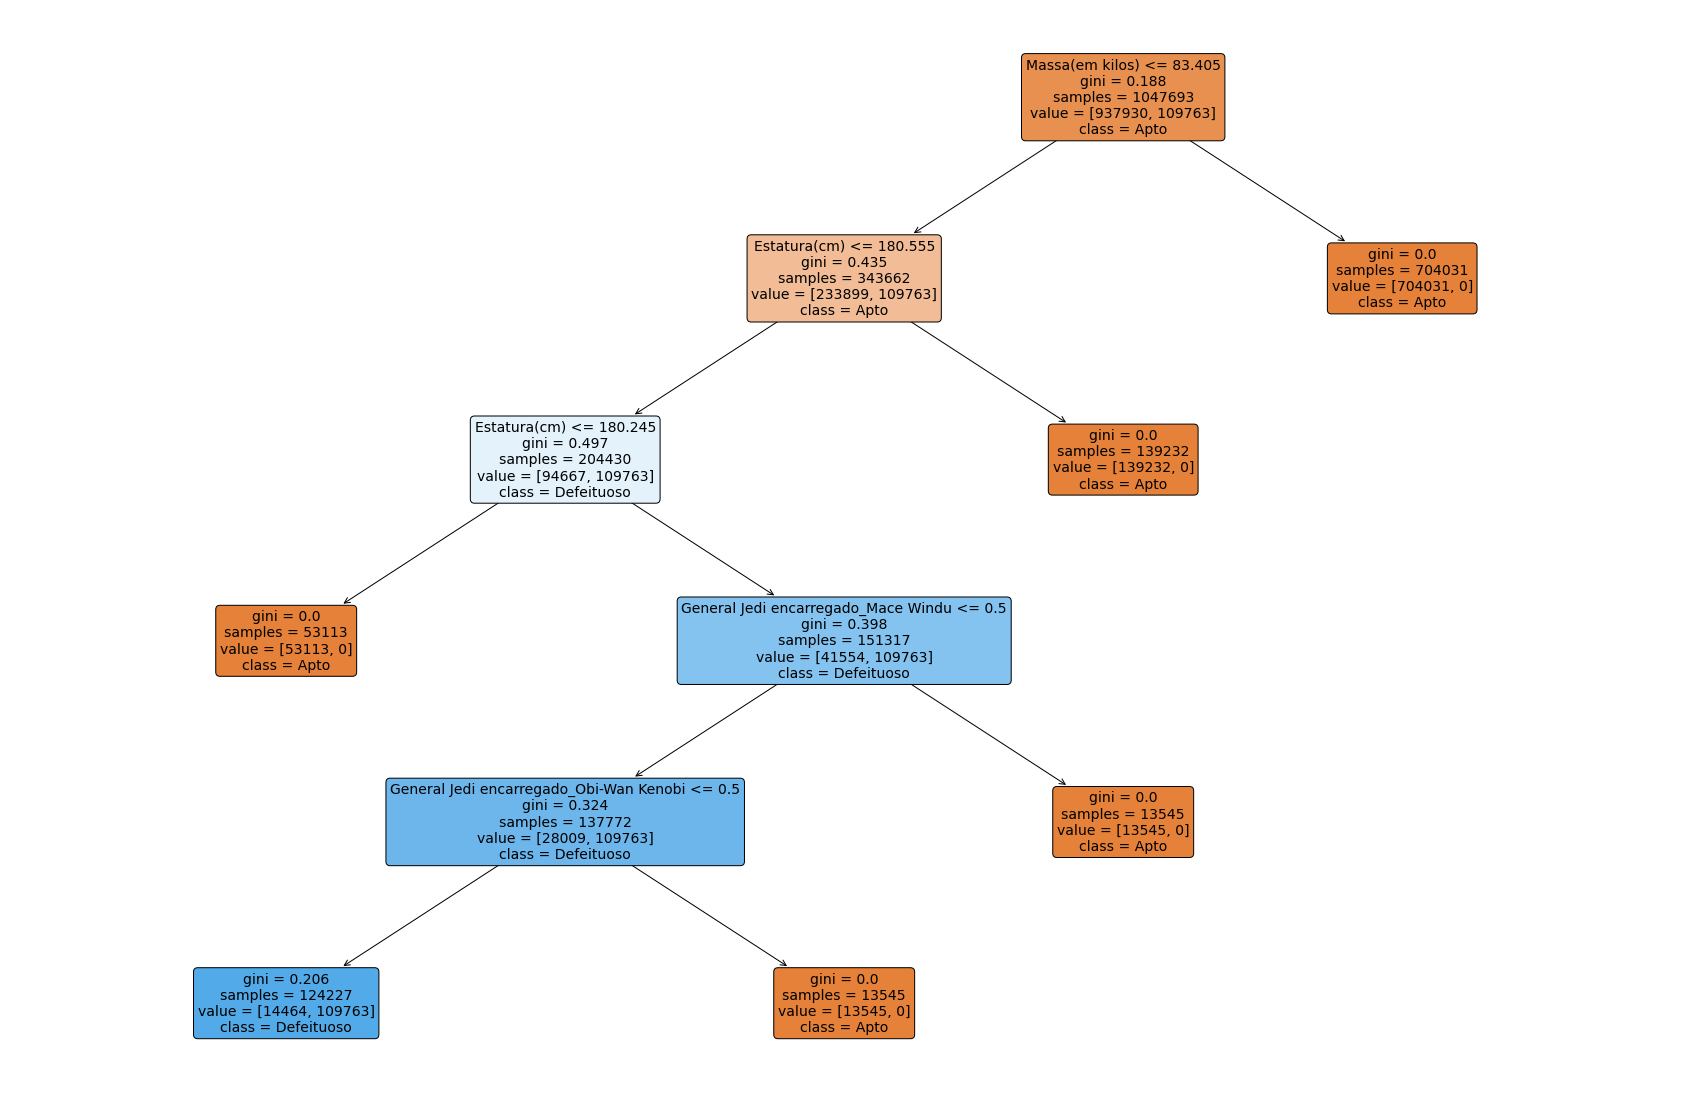

In [119]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit( df_fit, df[target] ) # é a porra do treinamento da IA

plt.figure(figsize=(30,20))
a = plot_tree(clf,
              feature_names= df_fit.columns,
              class_names=df[target].unique(),
              filled=True,
              rounded=True,
              fontsize=14)

## Análise desconsiderando Jedi

Será que sem considerar a variável de Jedi, podemos discriminar os defeituosos dos não defeituosos?

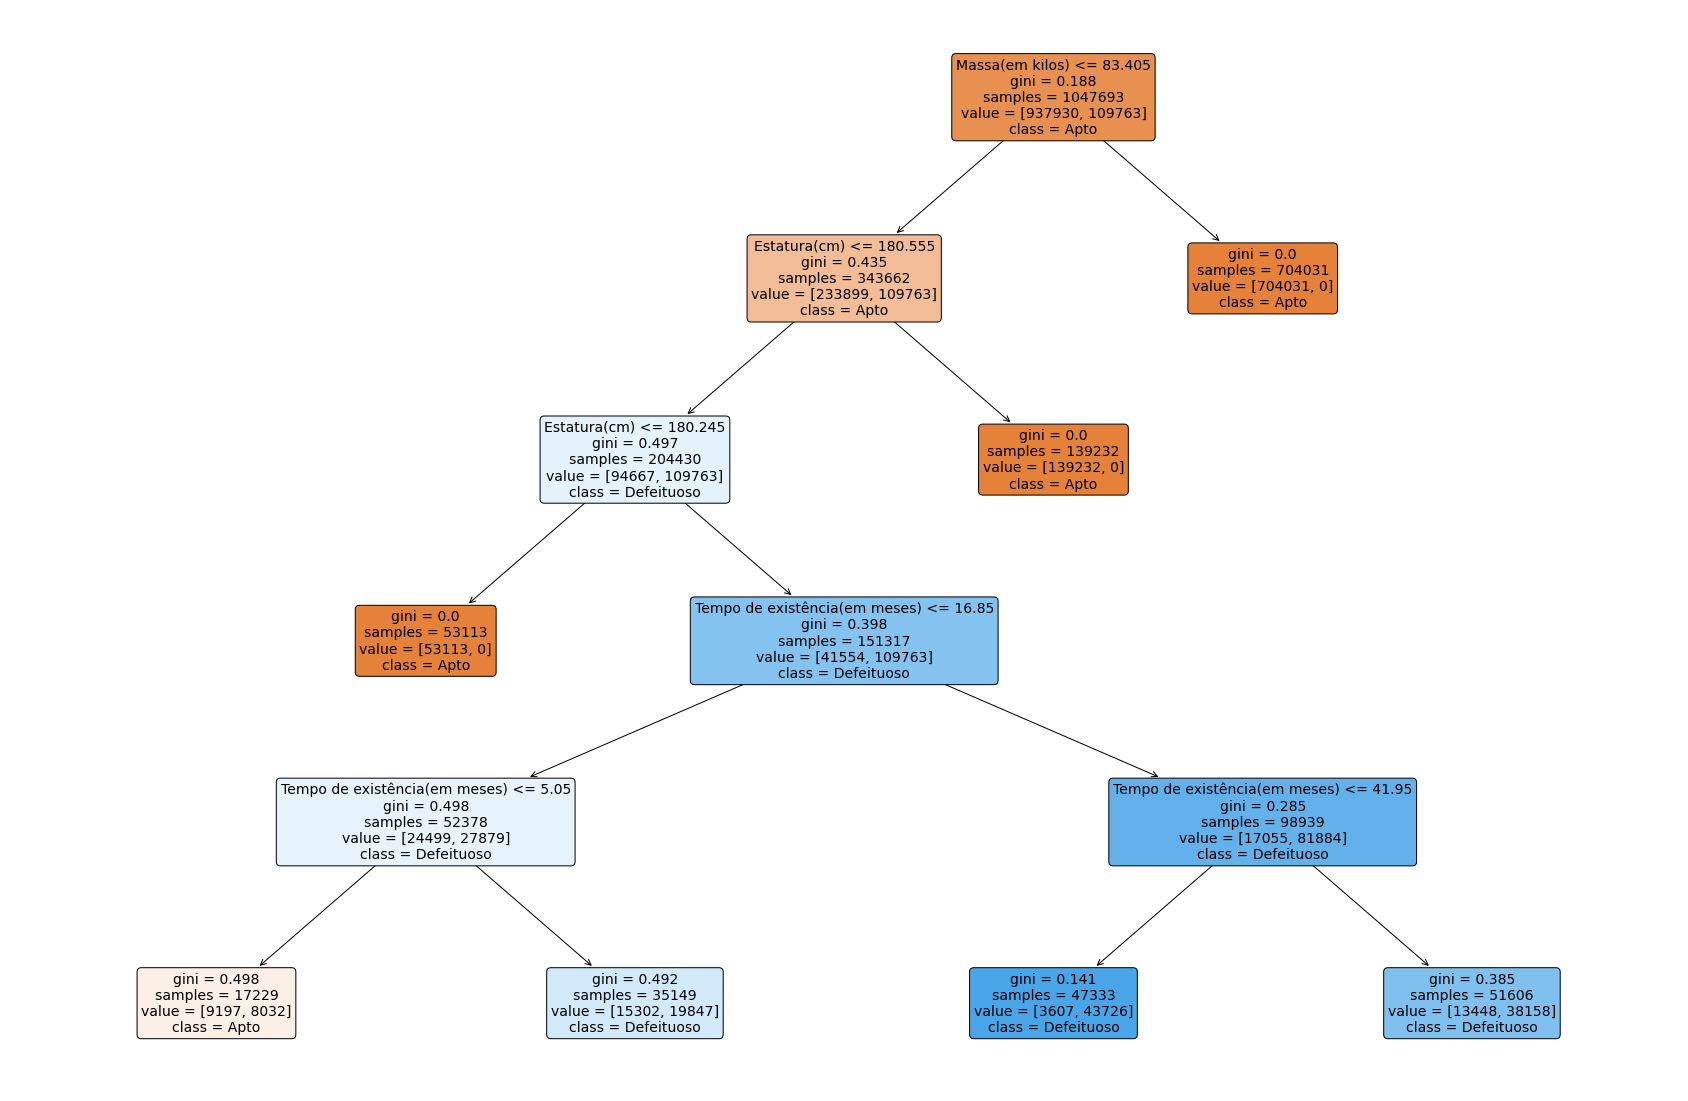

In [121]:
target = "Status "
features = df.columns.tolist()[1:-1]
features_cat = df[features].dtypes[ df[features].dtypes == "object" ].index.tolist()
features_num = list(set(features) - set(features_cat))
features_cat.remove("General Jedi encarregado")

onehot = preprocessing.OneHotEncoder(sparse=False)
onehot.fit(df[features_cat])

df_onehot = pd.DataFrame( onehot.transform(df[features_cat]),
                          columns=onehot.get_feature_names(features_cat))

df_fit = pd.concat( [df[features_num].reset_index(drop=True), df_onehot], axis=1)

clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit( df_fit, df[target] ) # é a porra do treinamento da IA

plt.figure(figsize=(30,20))
a = plot_tree(clf,
              feature_names= df_fit.columns,
              class_names=df[target].unique(),
              filled=True,
              rounded=True,
              fontsize=14)